# Load data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('BankNote_Authentication.csv')

In [4]:
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


# Plot correlations

<AxesSubplot:>

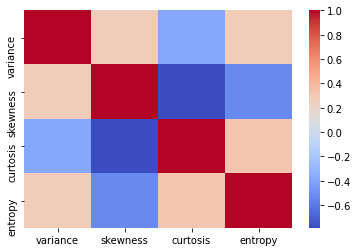

In [5]:
correlations = df.drop(columns=['class']).corr()
sns.heatmap(correlations,cmap='coolwarm')

In [6]:
data = df.values
train_data, test_data = train_test_split(data,test_size=0.2)

In [7]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

# Define functions

In [8]:
def label_counts(data):
    counts = {}
    for row in data:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [9]:
def classify(data):
    labels = data[:,-1]
    classes,classes_count = np.unique(labels,return_counts=True)
    
    max_index = classes_count.argmax()
    classification = classes[max_index]
    
    return classification

In [10]:
# split the dataset based on wether a feature > value
def split_by_value(data,column,value):
    left = data[data[:,column] <= value]
    right = data[data[:,column] > value]
    
    return left,right

In [11]:
def gini(data):
    
    impurity = 1
    
    class_counts = label_counts(data)
    for label in class_counts:
        impurity -= (class_counts[label]/len(data))**2
    
    return impurity

In [12]:
gini(data)

0.49386310125882926

In [13]:
def information_gain(current_uncertainity,left,right):
    
    weight = float(len(left)/(len(left)+len(right)))
    
    return current_uncertainity - (weight*gini(left) + (1-weight)*gini(right))


In [14]:
idx_to_feature = {0: 'variance', 1: 'skewness',2: 'curtosis', 3: 'entropy', 4: 'class'}
feature_to_idx = {'variance':0, 'skewness':1, 'curtosis':2, 'entropy':3, 'class':4}

In [15]:
def fetch_possible_splits(data):
    
    possible_splits = {}
    n_columns = data.shape[1]
    for column in range(n_columns - 1):        
        possible_splits[column] = []
        values = data[:, column]
        unique_vals = np.unique(values)

        for val_index in range(len(unique_vals)):
            if val_index != 0:
                current = unique_vals[val_index]
                previous = unique_vals[val_index - 1]
                split = (current + previous) / 2
                
                possible_splits[column].append(split)
    
    return possible_splits

In [16]:
def best_partition(data,possible_splits):
    
    highest_gain = 0
    current_uncertainity = gini(data)
    n_features = data.shape[1] - 1
    
    for column in possible_splits:
        
        for val in possible_splits[column]:
            
            left,right = split_by_value(data,column,val)
            
            info_gain = information_gain(current_uncertainity,left,right)
            
            if info_gain > highest_gain:
                highest_gain = info_gain
                best_feature = column
                best_value = val
        
    return best_feature,best_value
        

In [17]:
def check_single_class(data):
    
    labels = data[:,-1]
    
    unique_labels = np.unique(labels)
    
    if len(unique_labels) == 1:
        return True
    else:
        return False

# ooped

In [20]:
class Leaf: # represents decision making shiz
    
    def __init__(self,data):
        self.classification = classify(data) # the leaf returns the classification of the data

In [21]:
class Node:
    
    def __init__(self,left_branch,right_branch,feature,value):
        self.feature = feature
        self.value = value
        self.left_branch = left_branch
        self.right_branch = right_branch

In [43]:
def build_tree(data,min_samples):
    
    if check_single_class(data) or (len(data)<min_samples): # it will go deep enough to a point where its a single class or a single sample
        leaf = Leaf(data)
        return leaf
    
    else:
        potential_split = fetch_possible_splits(data)
        feature,value = best_partition(data,potential_split)

        true_data,false_data = split_by_value(data,feature,value)
        
        
        
        left_branch = build_tree(true_data,min_samples)
        
        right_branch = build_tree(false_data,min_samples)
        
        
        return Node(left_branch,right_branch,feature,value)

In [44]:
def classify_example(example,node):
    
    if isinstance(node,Leaf):
        return node.classification
    
    if example[node.feature] <= node.value:
        return classify_example(example,node.left_branch)
    else:
        return classify_example(example,node.right_branch)
        

# not ooped

In [49]:
def build_tree(data,min_samples):

    if check_single_class(data) or (len(data)<min_samples):
        classification = classify(data)
        return classification

    else:
        potential_split = fetch_possible_splits(data)
        feature,value = best_partition(data,potential_split)

        left,right = split_by_value(data,feature,value)
    
        question = "{} <= {}".format(idx_to_feature[feature],value)
        sub_tree = {question:[]}

      # left satisifies x <= value
        true = build_tree(left,min_samples)

        false = build_tree(right,min_samples)

        if true == false:
            sub_tree = true
        else:
            sub_tree[question].append(true)
            sub_tree[question].append(false)

        return sub_tree


In [50]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_to_idx[feature_name]] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [51]:
from pprint import pprint
tree = build_tree(train_data,2)
print(tree)

{'variance <= 0.32016500000000003': [{'skewness <= 6.70445': [{'variance <= -0.458565': [{'curtosis <= 6.21865': [1.0, {'skewness <= -4.74175': [1.0, {'variance <= -2.1171': [{'variance <= -2.6237500000000002': [0.0, 1.0]}, 0.0]}]}]}, {'curtosis <= 4.84085': [{'skewness <= 5.45355': [{'curtosis <= 2.62465': [1.0, {'variance <= -0.365255': [1.0, 0.0]}]}, 0.0]}, 0.0]}]}, {'variance <= -3.4448999999999996': [1.0, 0.0]}]}, {'curtosis <= -4.3856': [{'variance <= 3.30405': [1.0, 0.0]}, {'variance <= 1.5922': [{'curtosis <= -2.923': [1.0, {'entropy <= -0.0610043': [{'variance <= 0.450925': [{'variance <= 0.400865': [0.0, 1.0]}, 0.0]}, {'curtosis <= 1.85305': [{'skewness <= 3.6109': [1.0, 0.0]}, 0.0]}]}]}, {'variance <= 2.0388': [{'curtosis <= -2.6483499999999998': [1.0, 0.0]}, 0.0]}]}]}]}


In [52]:
pred = []
for i in range(len(test_data)):
    pred.append(classify_example(test_data[i],tree))

In [53]:
np.sum(np.array(pred) == test_data[:,-1])/len(test_data)

0.9854545454545455